In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow.keras import layers
import plotly.express as px


In [6]:
#Makes numpy values easier to read
np.set_printoptions(precision=3, suppress=True)

In [7]:
#Read data into pandas DataFrame
dataframe = pd.read_csv(r"C:\Users\ameli\OneDrive\Desktop\heart_disease\Heart_Disease_Prediction.csv")
#Plot data using plotly
#explicitly construct a color sequence
#bar graph
fig = px.bar(dataframe, x="Sex", y="Age", height=400, color="Heart Disease", title="Heart disease in patients")
fig.show()



In [8]:
dataframe.head(16)


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence
5,65,1,4,120,177,0,0,140,0,0.4,1,0,7,Absence
6,56,1,3,130,256,1,2,142,1,0.6,2,1,6,Presence
7,59,1,4,110,239,0,2,142,1,1.2,2,1,7,Presence
8,60,1,4,140,293,0,2,170,0,1.2,2,2,7,Presence
9,63,0,4,150,407,0,2,154,0,4.0,2,3,7,Presence


In [9]:
#Target variable:
dataframe['target'] = np.where(dataframe['Sex']==1, 0, 1)


In [32]:
#Split data in training, validation, and test sets:
heart_train, heart_val, heart_test = np.split(dataframe.sample(frac=1), [int(0.6 *len(dataframe)), int(0.9 *len(dataframe))])
#print the values:
print(heart_train, " this is the training set.")
print(heart_val, " this is the validation set.")
print(heart_test, "this is the test set.")
#Note: target variable appears here

     Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  EKG results  \
269   67    1                4  160          286             0            2   
68    44    0                3  118          242             0            0   
61    51    0                4  130          305             0            0   
51    52    1                2  128          205             1            0   
72    70    1                2  156          245             0            2   
..   ...  ...              ...  ...          ...           ...          ...   
180   42    1                3  120          240             1            0   
107   60    0                4  150          258             0            2   
58    59    0                4  174          249             0            0   
189   70    1                3  160          269             0            0   
127   52    0                3  136          196             0            2   

     Max HR  Exercise angina  ST depression  Slope 

In [11]:
#Creating input pipeline using tf.data:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop('target')
    #df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
    np.array(dataframe)[:, None] #converting to a numpy array before indexing
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

In [12]:
batch_size = 5
train_ds = df_to_dataset(heart_train, batch_size=batch_size)

In [13]:
[(train_features, label_batch)] = train_ds.take(1)
print('List of features:', list(train_features.keys()))

List of features: ['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium', 'Heart Disease']


In [14]:
print('A batch of ages:', train_features['Age'])

A batch of ages: tf.Tensor([39 44 56 54 67], shape=(5,), dtype=int64)


In [15]:
print('A batch of targets:', label_batch)

A batch of targets: tf.Tensor([0 0 0 0 0], shape=(5,), dtype=int32)


In [16]:
#applying keras processing layers for numerical columns
def get_normal_layer(feature, dataframe):
    #Creates normalization layer for the feature:
    normal = layers.Normalization(axis=None)
    #Prepare dataset that only yields the feature:
    feature_ds = dataframe.map(lambda x, y: x[feature])
    #Learn stats of the data:
    normal.adapt(feature_ds)
    
    return normal

In [17]:
max_hr_col = train_features['Max HR']
layer = get_normal_layer('Max HR', train_ds)
layer(max_hr_col)
#similar process can be done for categorical cloumns

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([ 1.412,  1.029, -0.291, -1.696,  0.603], dtype=float32)>

In [18]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [19]:
test_type_col = train_features['Age']
test_type_layer = get_category_encoding_layer(name='Age',
                                              dataset=train_ds,
                                              dtype='int64',
                                              max_tokens=5)
test_type_layer(test_type_col)

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([1., 1., 0., 0., 0.], dtype=float32)>

In [20]:
#preprocess selected features to train model on:
batch_size = 150
train_ds = df_to_dataset(heart_train, batch_size=batch_size)
val_ds = df_to_dataset(heart_val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(heart_test, shuffle=False, batch_size=batch_size)

In [21]:
all_inputs = []
encoded_features = []

#Numerical features:
for header in ['Max HR']:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normal_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

In [22]:
#turn categorical values into int indeces:
age_col = tf.keras.Input(shape=(1,), name='Age', dtype='int64')
encoding_layer = get_category_encoding_layer(name='Age',
                                   dataset=train_ds,
                                   dtype='int64',
                                   max_tokens=5)
encoded_age_col = encoding_layer(age_col)
all_inputs.append(age_col)
encoded_features.append(encoded_age_col)


In [23]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

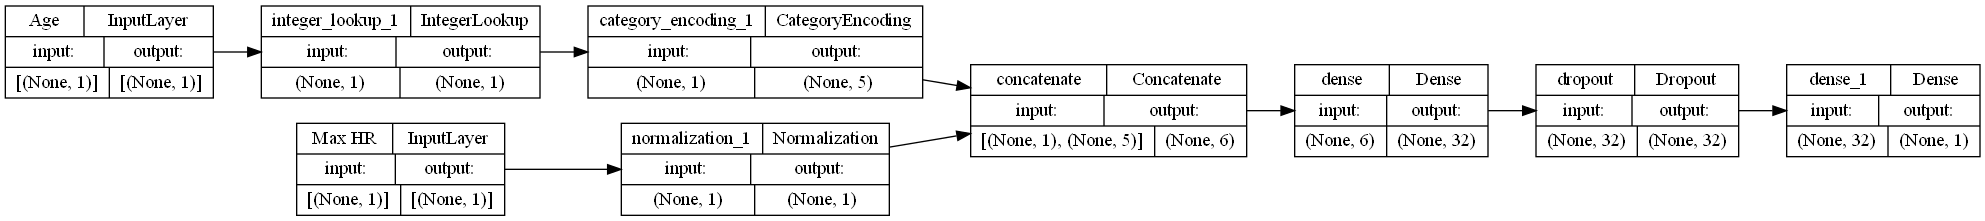

In [25]:
#Connectivity graph
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [26]:
#train the data
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


C:\Users\ameli\anaconda3\lib\site-packages\keras\engine\functional.py:639: UserWarning:

Input dict contained keys ['Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium', 'Heart Disease'] which did not match any model input. They will be ignored by the model.



2/2 [==============================] - 1s 335ms/step - loss: 0.6613 - accuracy: 0.6358 - val_loss: 0.6184 - val_accuracy: 0.7778
Epoch 2/10
2/2 [==============================] - 0s 32ms/step - loss: 0.6846 - accuracy: 0.6358 - val_loss: 0.6154 - val_accuracy: 0.7778
Epoch 3/10
2/2 [==============================] - 0s 29ms/step - loss: 0.6623 - accuracy: 0.6420 - val_loss: 0.6130 - val_accuracy: 0.7778
Epoch 4/10
2/2 [==============================] - 0s 29ms/step - loss: 0.6493 - accuracy: 0.6420 - val_loss: 0.6105 - val_accuracy: 0.7778
Epoch 5/10
2/2 [==============================] - 0s 34ms/step - loss: 0.6643 - accuracy: 0.6358 - val_loss: 0.6080 - val_accuracy: 0.7778
Epoch 6/10
2/2 [==============================] - 0s 50ms/step - loss: 0.6996 - accuracy: 0.6358 - val_loss: 0.6056 - val_accuracy: 0.7778
Epoch 7/10
2/2 [==============================] - 0s 30ms/step - loss: 0.6690 - accuracy: 0.6420 - val_loss: 0.6031 - val_accuracy: 0.7778
Epoch 8/10
2/2 [=====================

In [31]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

1/1 [==============================] - 0s 25ms/step - loss: 0.6853 - accuracy: 0.5926
Accuracy 0.5925925970077515


In [33]:
#Basic linear regression using plotly:
fig2 = px.scatter(
    dataframe, 
    x='Age', 
    y='Max HR', 
    opacity=0.65, 
    trendline='ols', 
    trendline_color_override='darkblue')
fig2.show()